In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import scipy
from sklearn.model_selection import GroupKFold
from sklearn import linear_model
from lineartree import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
def rae(actual, predicted):
    numerator = np.sum(np.abs(predicted - actual))
    denominator = np.sum(np.abs(np.mean(actual) - actual))
    return numerator / denominator

In [3]:
def peak_eV_nm(peak_eV):
    return 1239.84193/peak_eV

In [4]:
def FWHM_eV_nm(peak_eV,fwhm_eV):
    return  2*(1239.84193/(peak_eV-fwhm_eV/2) - 1239.84193/(peak_eV))

In [5]:
#Test Linear Regression on Train/Val set, 10-fold cross validation (Group splits), UV Peak, FWHM (eV), Normalized
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random forest regression models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 15, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=13, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth= 12, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

#Split groups for cross validation by Experiment number
gkf = GroupKFold(n_splits=10)
matrix = np.zeros([10,13])
matrix_fwhm = np.zeros([10,13])
matrix_cascade = np.zeros([10,14])

j = 0
#Loop through the 10 splits
for train_index, test_index in gkf.split(X, groups=group):
    #Separate out training and test sets
    X_train = X.iloc[train_index, :]
    X2_train = X2.iloc[train_index, :]
    y_train = y[train_index]
    z_train = z[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    z_test = z[test_index]

    #prediction for Peak
    regressor_peak.fit(X_train, y_train)
    y_pred = regressor_peak.predict(X_test)
    #prediction for FWHM (direct)
    regressor_fwhm.fit(X_train, z_train)
    y_pred_fwhm = regressor_fwhm.predict(X_test)
    #prediction for FWHM (cascade)
    regressor_cascade.fit(X2_train, z_train)
    X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
    y_pred_cascade = regressor_cascade.predict(X_test)

    #errors in eV (normalized)
    
    #UN-normalize eV predictions by scaling with ratio

    ratio = (1239.84193/400 - 1239.84193/620)
    ratio2 = 0.35
    matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
    matrix[j,1] = metrics.r2_score(y_test, y_pred)
    matrix[j,2] = rae(y_test, y_pred)
    matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
    matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
    matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
    matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

    matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
    matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
    matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
    matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

    #errors in nm
    #UNnormalize the data first
    y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    z_test = z_test*(0.35)+0.05
    y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
    y_pred_cascade = y_pred_cascade*(0.35)+0.05
    
    #Calculate data in nm and eV
    matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
    matrix[j,8:13] = regressor_peak.feature_importances_

    matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
    matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

    matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
    matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

    j+=1

matrix_2 = np.zeros([1,21])
matrix_2[0,:8] = matrix.mean(0)[:8]
matrix_2[0,8:16] = np.std(matrix[:,:8], axis=0)
matrix_2[0,16:21] = matrix.mean(0)[8:13]

matrix_3 = np.zeros([1,21])
matrix_3[0,:8] = matrix_fwhm.mean(0)[:8]
matrix_3[0,8:16] = np.std(matrix_fwhm[:,:8], axis=0)
matrix_3[0,16:21] = matrix_fwhm.mean(0)[8:13]

matrix_4 = np.zeros([1,22])
matrix_4[0,:8] = matrix_cascade.mean(0)[:8]
matrix_4[0,8:16] = np.std(matrix_cascade[:,:8], axis=0)
matrix_4[0,16:22] = matrix_cascade.mean(0)[8:14]

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV): \t", "{:.4f}".format(matrix_2[0,0]), "{:.4f}".format(matrix_2[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_2[0,1]), "{:.4f}".format(matrix_2[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_2[0,2]), "{:.4f}".format(matrix_2[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_2[0,3]), "{:.4f}".format(matrix_2[0,11]))
print("Importances\t", matrix_2[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_2[0,4]), "{:.4f}".format(matrix_2[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_2[0,5]), "{:.4f}".format(matrix_2[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_2[0,6]), "{:.4f}".format(matrix_2[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_2[0,7]), "{:.4f}".format(matrix_2[0,15]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_3[0,0]), "{:.4f}".format(matrix_3[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_3[0,1]), "{:.4f}".format(matrix_3[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_3[0,2]), "{:.4f}".format(matrix_3[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_3[0,3]), "{:.4f}".format(matrix_3[0,11]))
print("Importances\t", matrix_3[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_3[0,4]), "{:.4f}".format(matrix_3[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_3[0,5]),"{:.4f}".format(matrix_3[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_3[0,6]), "{:.4f}".format(matrix_3[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_3[0,7]), "{:.4f}".format(matrix_3[0,15]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_4[0,0]), "{:.4f}".format(matrix_4[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_4[0,1]), "{:.4f}".format(matrix_4[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_4[0,2]), "{:.4f}".format(matrix_4[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_4[0,3]), "{:.4f}".format(matrix_4[0,11]))
print("Importances\t", matrix_4[0,16:22])
print("MAE (nm):\t","{:.4f}".format(matrix_4[0,4]), "{:.4f}".format(matrix_4[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_4[0,5]),"{:.4f}".format(matrix_4[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_4[0,6]), "{:.4f}".format(matrix_4[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_4[0,7]), "{:.4f}".format(matrix_4[0,15]))

np.savetxt("RF_UV_Val_peak.csv", matrix, delimiter=",")
np.savetxt("RF_UV_Val_fwhm.csv", matrix_fwhm, delimiter=",")
np.savetxt("RF_UV_Val_cascade.csv", matrix_cascade, delimiter=",")

Absorbance Peak
MAE (eV): 	 0.0231 0.0036
R2 (eV):	 0.9608 0.0187
RAE (eV):	 0.1540 0.0288
RMSE (eV):	 0.0345 0.0072
Importances	 [0.1243  0.17592 0.22295 0.07188 0.40497]
MAE (nm):	 4.8309 0.7678
R2 (nm):	 0.9575 0.0244
RAE (nm):	 0.1542 0.0296
RMSE (nm):	 7.3739 1.8568
Absorbance FWHM (direct)
MAE (eV):	 0.0076 0.0007
R2 (eV):	 0.7424 0.0809
RAE (eV):	 0.3866 0.0394
RMSE (eV):	 0.0125 0.0026
Importances	 [0.13205 0.19867 0.19409 0.15428 0.3209 ]
MAE (nm):	 1.8722 0.2206
R2 (nm):	 0.7536 0.0829
RAE (nm):	 0.3662 0.0482
RMSE (nm):	 3.0469 0.6949
Absorbance FWHM (cascade)
MAE (eV):	 0.0071 0.0008
R2 (eV):	 0.7615 0.0785
RAE (eV):	 0.3626 0.0449
RMSE (eV):	 0.0120 0.0025
Importances	 [0.05869 0.11871 0.21049 0.11211 0.16241 0.3376 ]
MAE (nm):	 1.7087 0.2042
R2 (nm):	 0.7690 0.0985
RAE (nm):	 0.3342 0.0441
RMSE (nm):	 2.9300 0.7678


In [6]:
#Test Linear Regression on Train/Val set, 10-fold cross validation (Group splits), PL Peak, FWHM (eV), Normalized
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random Forest models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 14, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 5,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=19, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth=18, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 2,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

#Split groups for cross validation by Experiment number
gkf = GroupKFold(n_splits=10)
matrix = np.zeros([10,13])
matrix_fwhm = np.zeros([10,13])
matrix_cascade = np.zeros([10,14])

j = 0
#Loop through the 10 splits
for train_index, test_index in gkf.split(X, groups=group):
    #Separate out training and test sets
    X_train = X.iloc[train_index, :]
    X2_train = X2.iloc[train_index, :]
    y_train = y[train_index]
    z_train = z[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    z_test = z[test_index]

    #prediction for Peak
    regressor_peak.fit(X_train, y_train)
    y_pred = regressor_peak.predict(X_test)
    #prediction for FWHM (direct)
    regressor_fwhm.fit(X_train, z_train)
    y_pred_fwhm = regressor_fwhm.predict(X_test)
    #prediction for FWHM (cascade)
    regressor_cascade.fit(X2_train, z_train)
    X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
    y_pred_cascade = regressor_cascade.predict(X_test)

    #errors in eV (normalized)
    
    #UN-normalize eV predictions by scaling with ratio

    ratio = (1239.84193/400 - 1239.84193/620)
    ratio2 = 0.35
    matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
    matrix[j,1] = metrics.r2_score(y_test, y_pred)
    matrix[j,2] = rae(y_test, y_pred)
    matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
    matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
    matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
    matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

    matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
    matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
    matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
    matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

    #errors in nm
    #UNnormalize the data first
    y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    z_test = z_test*(0.35)+0.05
    y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
    y_pred_cascade = y_pred_cascade*(0.35)+0.05
    
    #Calculate data in nm and eV
    matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
    matrix[j,8:13] = regressor_peak.feature_importances_

    matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
    matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

    matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
    matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

    j+=1

matrix_2 = np.zeros([1,21])
matrix_2[0,:8] = matrix.mean(0)[:8]
matrix_2[0,8:16] = np.std(matrix[:,:8], axis=0)
matrix_2[0,16:21] = matrix.mean(0)[8:13]

matrix_3 = np.zeros([1,21])
matrix_3[0,:8] = matrix_fwhm.mean(0)[:8]
matrix_3[0,8:16] = np.std(matrix_fwhm[:,:8], axis=0)
matrix_3[0,16:21] = matrix_fwhm.mean(0)[8:13]

matrix_4 = np.zeros([1,22])
matrix_4[0,:8] = matrix_cascade.mean(0)[:8]
matrix_4[0,8:16] = np.std(matrix_cascade[:,:8], axis=0)
matrix_4[0,16:22] = matrix_cascade.mean(0)[8:14]

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_2[0,0]), "{:.4f}".format(matrix_2[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_2[0,1]), "{:.4f}".format(matrix_2[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_2[0,2]), "{:.4f}".format(matrix_2[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_2[0,3]), "{:.4f}".format(matrix_2[0,11]))
print("Importances\t", matrix_2[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_2[0,4]), "{:.4f}".format(matrix_2[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_2[0,5]), "{:.4f}".format(matrix_2[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_2[0,6]), "{:.4f}".format(matrix_2[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_2[0,7]), "{:.4f}".format(matrix_2[0,15]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_3[0,0]), "{:.4f}".format(matrix_3[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_3[0,1]), "{:.4f}".format(matrix_3[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_3[0,2]), "{:.4f}".format(matrix_3[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_3[0,3]), "{:.4f}".format(matrix_3[0,11]))
print("Importances\t", matrix_3[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_3[0,4]), "{:.4f}".format(matrix_3[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_3[0,5]),"{:.4f}".format(matrix_3[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_3[0,6]), "{:.4f}".format(matrix_3[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_3[0,7]), "{:.4f}".format(matrix_3[0,15]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_4[0,0]), "{:.4f}".format(matrix_4[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_4[0,1]), "{:.4f}".format(matrix_4[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_4[0,2]), "{:.4f}".format(matrix_4[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_4[0,3]), "{:.4f}".format(matrix_4[0,11]))
print("Importances\t", matrix_4[0,16:22])
print("MAE (nm):\t","{:.4f}".format(matrix_4[0,4]), "{:.4f}".format(matrix_4[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_4[0,5]),"{:.4f}".format(matrix_4[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_4[0,6]), "{:.4f}".format(matrix_4[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_4[0,7]), "{:.4f}".format(matrix_4[0,15]))

np.savetxt("RF_PL_Val_peak.csv", matrix, delimiter=",")
np.savetxt("RF_PL_Val_fwhm.csv", matrix_fwhm, delimiter=",")
np.savetxt("RF_PL_Val_cascade.csv", matrix_cascade, delimiter=",")

Emission Peak
MAE (eV):	 0.0182 0.0024
R2 (eV):	 0.9702 0.0075
RAE (eV):	 0.1423 0.0140
RMSE (eV):	 0.0260 0.0043
Importances	 [0.12071 0.19439 0.26315 0.07956 0.34219]
MAE (nm):	 4.0418 0.4532
R2 (nm):	 0.9712 0.0064
RAE (nm):	 0.1406 0.0130
RMSE (nm):	 5.6770 0.7717
Emission FWHM (direct)
MAE (eV):	 0.0073 0.0007
R2 (eV):	 0.6858 0.0824
RAE (eV):	 0.4554 0.0421
RMSE (eV):	 0.0114 0.0014
Importances	 [0.14966 0.18954 0.1674  0.15302 0.34037]
MAE (nm):	 1.7881 0.1417
R2 (nm):	 0.7587 0.0641
RAE (nm):	 0.4115 0.0333
RMSE (nm):	 2.7121 0.2586
Emission FWHM (cascade)
MAE (eV):	 0.0066 0.0006
R2 (eV):	 0.7274 0.0779
RAE (eV):	 0.4146 0.0397
RMSE (eV):	 0.0106 0.0013
Importances	 [0.09431 0.08545 0.15453 0.11793 0.16912 0.37865]
MAE (nm):	 1.6340 0.1159
R2 (nm):	 0.7858 0.0635
RAE (nm):	 0.3763 0.0321
RMSE (nm):	 2.5502 0.2403


In [7]:
#Train model on entire dataset (Absorbance)
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random forest regression models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 15, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=13, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth= 12, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)



matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z
j=0

#prediction for Peak
regressor_peak.fit(X_train, y_train)
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
regressor_fwhm.fit(X_train, z_train)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
regressor_cascade.fit(X2_train, z_train)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
matrix[j,8:13] = regressor_peak.feature_importances_

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("Importances\t", matrix[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("Importances\t", matrix_fwhm[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("Importances\t", matrix_cascade[0,8:14])
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Absorption Peak/FWHM Training Accuracy
Absorbance Peak
MAE (eV):	 0.0086
R2 (eV):	 0.9937
RAE (eV):	 0.0565
RMSE (eV):	 0.0144
Importances	 [0.12424 0.17571 0.22282 0.07293 0.4043 ]
MAE (nm):	 1.7796
R2 (nm):	 0.9932
RAE (nm):	 0.0558
RMSE (nm):	 3.0872
Absorbance FWHM (direct)
MAE (eV):	 0.0030
R2 (eV):	 0.9448
RAE (eV):	 0.1543
RMSE (eV):	 0.0059
Importances	 [0.13467 0.20084 0.19085 0.15388 0.31975]
MAE (nm):	 0.7159
R2 (nm):	 0.9560
RAE (nm):	 0.1372
RMSE (nm):	 1.3153
Absorbance FWHM (cascade)
MAE (eV):	 0.0039
R2 (eV):	 0.8788
RAE (eV):	 0.1992
RMSE (eV):	 0.0087
Importances	 [0.057   0.11709 0.21191 0.115   0.15697 0.34203]
MAE (nm):	 0.9120
R2 (nm):	 0.8897
RAE (nm):	 0.1747
RMSE (nm):	 2.0833


In [8]:
#Test Linear model on interpolation, UV Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe UV Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_UV_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_UV_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_UV_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Interpolation
Absorbance Peak
MAE (eV):	 0.0590
R2 (eV):	 0.7757
RAE (eV):	 0.4480
RMSE (eV):	 0.0749
MAE (nm):	 12.0384
R2 (nm):	 0.7970
RAE (nm):	 0.4269
RMSE (nm):	 14.9996
Absorbance FWHM (direct)
MAE (eV):	 0.0123
R2 (eV):	 0.5639
RAE (eV):	 0.6182
RMSE (eV):	 0.0163
MAE (nm):	 2.2418
R2 (nm):	 0.7376
RAE (nm):	 0.4158
RMSE (nm):	 3.2298
Absorbance FWHM (cascade)
MAE (eV):	 0.0115
R2 (eV):	 0.6439
RAE (eV):	 0.5756
RMSE (eV):	 0.0147
MAE (nm):	 2.1013
R2 (nm):	 0.7802
RAE (nm):	 0.3897
RMSE (nm):	 2.9562


In [9]:
#Test Linear model on extrapolation, UV Peak, FWHM (eV)

#Test data set (extrapolation)
df2 = pd.read_csv('CdSe UV Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_UV_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_UV_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_UV_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Extrapolation
Absorbance Peak
MAE (eV):	 0.0455
R2 (eV):	 0.9100
RAE (eV):	 0.2748
RMSE (eV):	 0.0597
MAE (nm):	 9.2551
R2 (nm):	 0.9185
RAE (nm):	 0.2613
RMSE (nm):	 11.9537
Absorbance FWHM (direct)
MAE (eV):	 0.0117
R2 (eV):	 0.7370
RAE (eV):	 0.4349
RMSE (eV):	 0.0162
MAE (nm):	 2.4522
R2 (nm):	 0.5866
RAE (nm):	 0.5432
RMSE (nm):	 3.3805
Absorbance FWHM (cascade)
MAE (eV):	 0.0114
R2 (eV):	 0.7691
RAE (eV):	 0.4239
RMSE (eV):	 0.0152
MAE (nm):	 2.4314
R2 (nm):	 0.6012
RAE (nm):	 0.5386
RMSE (nm):	 3.3201


In [10]:
# load dataset into Pandas DataFrame
test1 = pd.read_csv('testpoints1.csv')
test2 = pd.read_csv('testpoints2.csv')

test1 = test1[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
test2 = test2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]

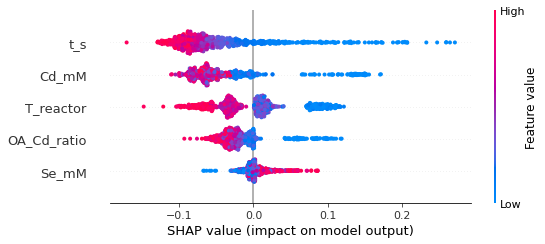

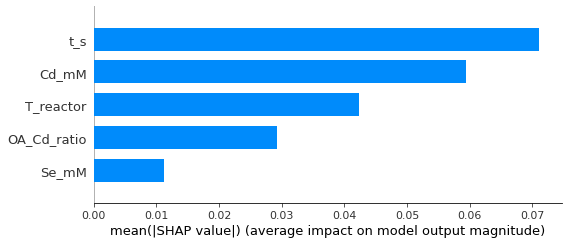

In [11]:
#SHAP on training data for Peak
import shap
tree_explainer = shap.TreeExplainer(regressor_peak)
shap_values = tree_explainer.shap_values(test1)
shap.summary_plot(shap_values, test1)
shap.summary_plot(shap_values, test1, plot_type="bar")
np.savetxt("RF_UV_peak_shap.csv", shap_values, delimiter=",")

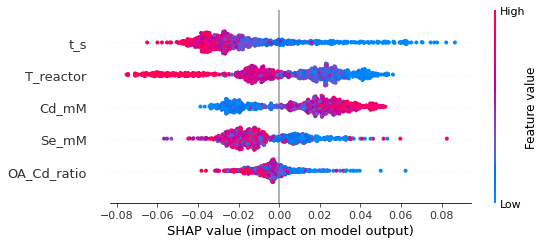

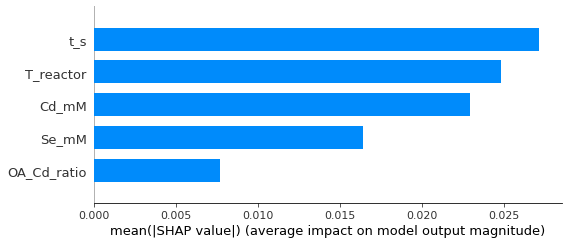

In [12]:
#SHAP on training data for FWHM
tree_explainer = shap.TreeExplainer(regressor_fwhm)
shap_values = tree_explainer.shap_values(test1)
shap.summary_plot(shap_values, test1)
shap.summary_plot(shap_values, test1, plot_type="bar")
np.savetxt("RF_UV_fwhm_shap.csv", shap_values, delimiter=",")

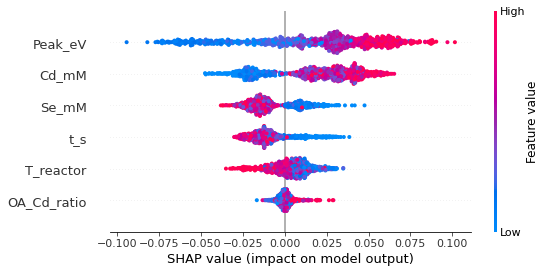

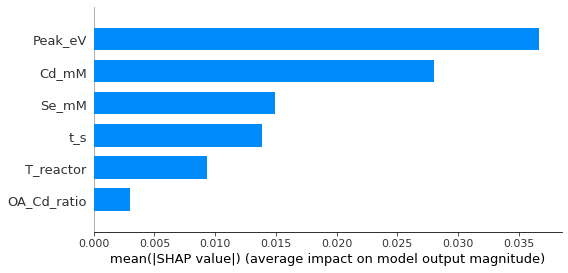

In [13]:
#SHAP on training data for Cascade
tree_explainer = shap.TreeExplainer(regressor_cascade)
shap_values = tree_explainer.shap_values(test2)
shap.summary_plot(shap_values, test2)
shap.summary_plot(shap_values, test2, plot_type="bar")
np.savetxt("RF_UV_cascade_shap.csv", shap_values, delimiter=",")

In [14]:
#Train model on entire dataset (Emission)
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random Forest models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 14, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 5,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=19, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth=18, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 2,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)
matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z
j=0

#prediction for Peak
regressor_peak.fit(X_train, y_train)
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
regressor_fwhm.fit(X_train, z_train)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
regressor_cascade.fit(X2_train, z_train)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
matrix[j,8:13] = regressor_peak.feature_importances_

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Training Accuracy' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("Importances\t", matrix[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("Importances\t", matrix_fwhm[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("Importances\t", matrix_cascade[0,8:14])
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Emission Peak/FWHM Training Accuracy
Emission Peak
MAE (eV):	 0.0069
R2 (eV):	 0.9954
RAE (eV):	 0.0529
RMSE (eV):	 0.0104
Importances	 [0.11842 0.1951  0.26853 0.07928 0.33867]
MAE (nm):	 1.5142
R2 (nm):	 0.9958
RAE (nm):	 0.0518
RMSE (nm):	 2.2220
Emission FWHM (direct)
MAE (eV):	 0.0034
R2 (eV):	 0.9211
RAE (eV):	 0.2094
RMSE (eV):	 0.0058
Importances	 [0.14778 0.19239 0.16726 0.15605 0.33652]
MAE (nm):	 0.8041
R2 (nm):	 0.9459
RAE (nm):	 0.1829
RMSE (nm):	 1.3225
Emission FWHM (cascade)
MAE (eV):	 0.0035
R2 (eV):	 0.8986
RAE (eV):	 0.2184
RMSE (eV):	 0.0066
Importances	 [0.09415 0.08676 0.1542  0.1167  0.16856 0.37963]
MAE (nm):	 0.8485
R2 (nm):	 0.9263
RAE (nm):	 0.1930
RMSE (nm):	 1.5426


In [15]:
#Test Linear model on interpolation, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Interpolation' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_PL_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_PL_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_PL_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Emission Peak/FWHM Interpolation
Emission Peak
MAE (eV):	 0.0530
R2 (eV):	 0.7977
RAE (eV):	 0.4404
RMSE (eV):	 0.0639
MAE (nm):	 11.6909
R2 (nm):	 0.8140
RAE (nm):	 0.4249
RMSE (nm):	 13.8308
Emission FWHM (direct)
MAE (eV):	 0.0107
R2 (eV):	 0.5448
RAE (eV):	 0.6274
RMSE (eV):	 0.0157
MAE (nm):	 2.6079
R2 (nm):	 0.6556
RAE (nm):	 0.5522
RMSE (nm):	 3.5641
Emission FWHM (cascade)
MAE (eV):	 0.0099
R2 (eV):	 0.6378
RAE (eV):	 0.5801
RMSE (eV):	 0.0140
MAE (nm):	 2.4040
R2 (nm):	 0.7211
RAE (nm):	 0.5090
RMSE (nm):	 3.2073


In [16]:
#Test Linear model on extrapolation, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Extrapolation' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_PL_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_PL_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_PL_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Emission Peak/FWHM Extrapolation
Emission Peak
MAE (eV):	 0.0373
R2 (eV):	 0.8827
RAE (eV):	 0.3009
RMSE (eV):	 0.0497
MAE (nm):	 8.3656
R2 (nm):	 0.8960
RAE (nm):	 0.2875
RMSE (nm):	 10.9184
Emission FWHM (direct)
MAE (eV):	 0.0095
R2 (eV):	 0.5956
RAE (eV):	 0.5421
RMSE (eV):	 0.0129
MAE (nm):	 2.2903
R2 (nm):	 0.4891
RAE (nm):	 0.6122
RMSE (nm):	 3.1949
Emission FWHM (cascade)
MAE (eV):	 0.0099
R2 (eV):	 0.5780
RAE (eV):	 0.5662
RMSE (eV):	 0.0132
MAE (nm):	 2.3209
R2 (nm):	 0.4930
RAE (nm):	 0.6204
RMSE (nm):	 3.1827


In [17]:
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

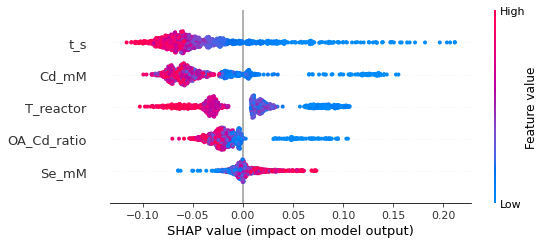

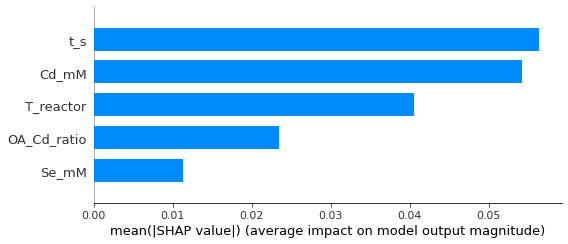

In [18]:
#SHAP on training data for Peak
import shap
tree_explainer = shap.TreeExplainer(regressor_peak)
shap_values = tree_explainer.shap_values(test1)
shap.summary_plot(shap_values, test1)
shap.summary_plot(shap_values, test1, plot_type="bar")
np.savetxt("RF_PL_peak_shap.csv", shap_values, delimiter=",")

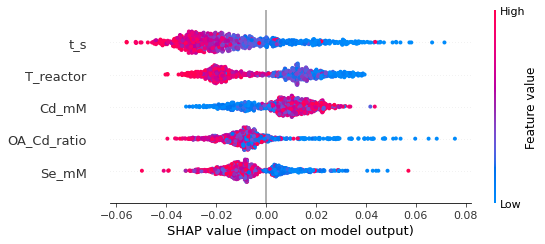

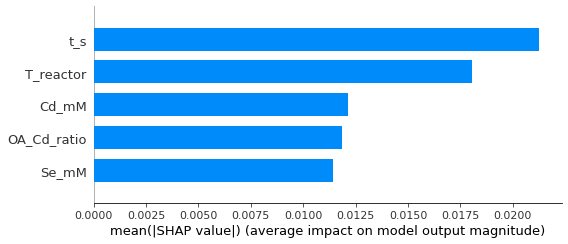

In [19]:
#SHAP on training data for FWHM
tree_explainer = shap.TreeExplainer(regressor_fwhm)
shap_values = tree_explainer.shap_values(test1)
shap.summary_plot(shap_values, test1)
shap.summary_plot(shap_values, test1, plot_type="bar")
np.savetxt("RF_PL_fwhm_shap.csv", shap_values, delimiter=",")

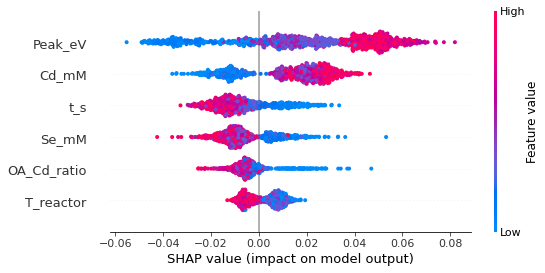

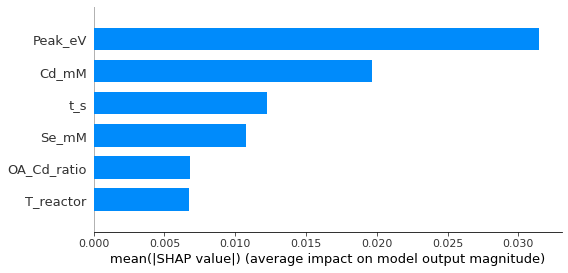

In [20]:
#SHAP on training data for FWHM (cascade)
tree_explainer = shap.TreeExplainer(regressor_cascade)
shap_values = tree_explainer.shap_values(test2)
shap.summary_plot(shap_values, test2)
shap.summary_plot(shap_values, test2, plot_type="bar")
np.savetxt("RF_PL_cascade_shap.csv", shap_values, delimiter=",")

In [21]:
random_points = pd.read_csv('randompoints.csv')
random_points = random_points[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]

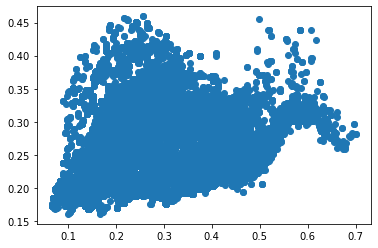

In [22]:
points1 = regressor_peak.predict(random_points)
points2 = regressor_fwhm.predict(random_points)
plt.scatter(points1,points2)

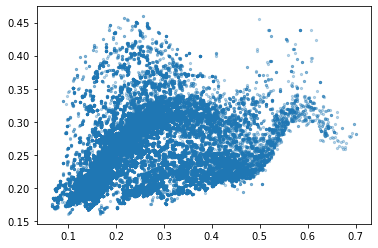

In [23]:
plt.scatter(points1,points2,s = 5, alpha = 0.3)